In [2]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np

import meep as mp

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# forward

设置不同角度的光源(0-25度) angle_reslution=0.2，光源的强度从0到25度线性降低，获取远场的强度分布并归一化

<Axes: xlabel='X', ylabel='Y'>

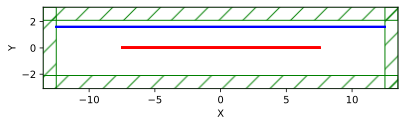

In [5]:
# if True compute flux (Gaussian source), if False compute DFT (Continue source)
compute_flux = True
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.01
resolution = 1 / grid

# thickness of PML
dpml = 1

##################### length parameter ################
source_height = 0.5  # 与逆向设计中的meta_grarting区域保持一致
input_wvg_length = 5
output_wvg_length = 5
design_region_x = 15
design_region_y = 0.2
sx = input_wvg_length + design_region_x + output_wvg_length + 2 * dpml

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

cell = mp.Vector3(sx, sy, 0)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)


####################### Sources ##########################
wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen

start_angle = 0
stop_angle = 25
sources = []
angle_resolution = 0.1
for ii in range(0, int(stop_angle / angle_resolution) + 1, 1):
    angle = ii * angle_resolution
    rot_angle = angle
    k_point = mp.Vector3(fcen * 1).rotate(mp.Vector3(z=1), np.radians(90 - rot_angle))
    sources.append(
        mp.Source(
            src=mp.GaussianSource(fcen, fwidth=fwidth),
            component=mp.Ez,
            center=mp.Vector3(y=0),
            size=mp.Vector3(x=design_region_x),
        )
    )
    # the amplitude of source is e_field, the intensity is square of e_field
    sources[ii].amplitude = np.sqrt(int(stop_angle / angle_resolution) - ii)

# angle = 5
# rot_angle = angle
# k_point = mp.Vector3(fcen * 1).rotate(mp.Vector3(z=1), np.radians(90 - rot_angle))
# sources.append(
#     mp.EigenModeSource(
#         src=mp.GaussianSource(fcen, fwidth=fwidth),
#         center=mp.Vector3(y=0),
#         size=mp.Vector3(x=sx - 2 * dpml),
#         direction=mp.NO_DIRECTION,
#         eig_kpoint=k_point,
#         eig_band=1,
#         eig_parity=mp.ODD_Z,
#         eig_match_freq=True,
#     )
# )
# sources[0].amplitude = 2

# set nomrlized source: amplitude is 1 -> flux is 1
# sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
#     fcen
# )

####################### Sources ##########################

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
)

# ############### Monitor ###################
nfreq = 1


near_region = mp.FluxRegion(
    center=mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0),
    size=mp.Vector3(sx - 2 * dpml, 0),
)

near_field = sim.add_mode_monitor(
    fcen,
    fwidth,
    nfreq,
    near_region,
)

near_dft = sim.add_dft_fields(
    [mp.Ez], fcen, fwidth, nfreq, center=near_region.center, size=near_region.size
)

# near2far_field
n2f_field = sim.add_near2far(
    fcen,
    0,
    nfreq,
    near_region,
)

# geometry plot
sim.plot2D()

In [ ]:
mp.Source()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000808001 s
Working in 2D dimensions.
Computational cell is 27 x 6.2 x 0 with resolution 100
time for set_epsilon = 1.63802 s
-----------
MPB solved for frequency_1(7.8003e-17,1.27389,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.00222335,1.27388,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.00444669,1.27388,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.00667002,1.27387,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.00889333,1.27385,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.0111166,1.27384,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.0133399,1.27382,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.0155631,1.27379,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.0177862,1.27376,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.0200093,1.27373,0) = 1.27389 after 84 iters
MPB solved for frequency_1(0.0222324,1.27369,0) = 1.273

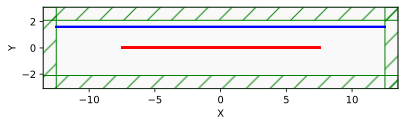

In [16]:
mpt = mp.Vector3(0, 0.5 * sy - dpml - 0.5 * near_field_height, 0)

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim.run(
    mp.at_every(1, Animate),
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
)


In [17]:
filename = "base_simulation_angle_source.mp4"
Animate.to_mp4(10, filename)

from IPython.core.display import Video
Video(filename)


Generating MP4...


**DFT field** 

In [18]:
output_dft = sim.get_dft_array(near_dft, mp.Ez, 0)
[x, y, z, w] = sim.get_array_metadata(dft_cell=near_dft) # type: ignore

Text(0, 0.5, '$ E_z $')

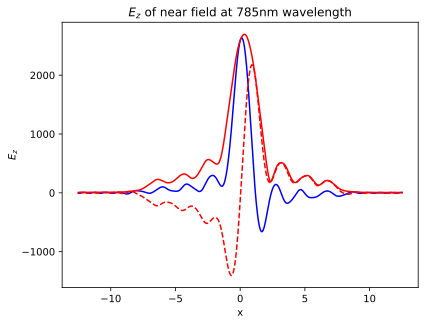

In [25]:
figure, ax = plt.subplots()
plt.plot(x, np.real(output_dft), "-b")
plt.plot(x, np.imag(output_dft), "--r")
plt.plot(x, np.abs(output_dft), "-r")
plt.title(r"$ E_z $ of near field at 785nm wavelength")
ax.set_xlabel("x")
ax.set_ylabel(r"$ E_z $")

The angle of maximum intensity is 3.597662342146503


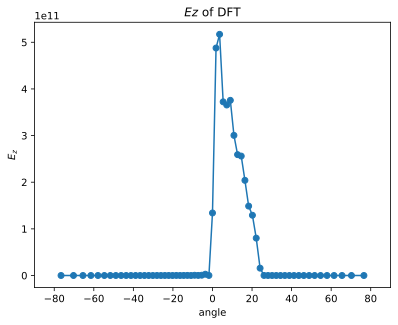

In [19]:
# dft ot near field
kx = np.fft.fftshift(np.fft.fftfreq(len(x), grid))
near_field_fft = np.fft.fftshift(np.fft.fft(output_dft))

k = 1 / wvl
kx[np.abs(kx) > k] = np.nan
angle = np.arcsin(kx / k) * 180 / np.pi

figure, ax = plt.subplots()
plt.plot(angle, np.abs(near_field_fft) ** 2, "-o")
# plt.scatter(angle, near_field_fft)
plt.title(r"$ Ez $ of DFT")
ax.set_xlabel("angle")
ax.set_ylabel(r"$ E_z $")
ax.set_xlim(-90, 90)

max_index = np.argmax(np.abs(near_field_fft) ** 2)
print(f"The angle of maximum intensity is {angle[max_index]}")


source.amplitude is 1, flux is 15.4

In [20]:
am = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(fcen)
print(np.abs(am))
print((1 / np.abs(am)) ** 2)  


0.25477707006369427
15.405624999999999


**far field**

Output_angle of grating coupler: 2.7462612353703206 degree
max of far field: 70.91480510943883


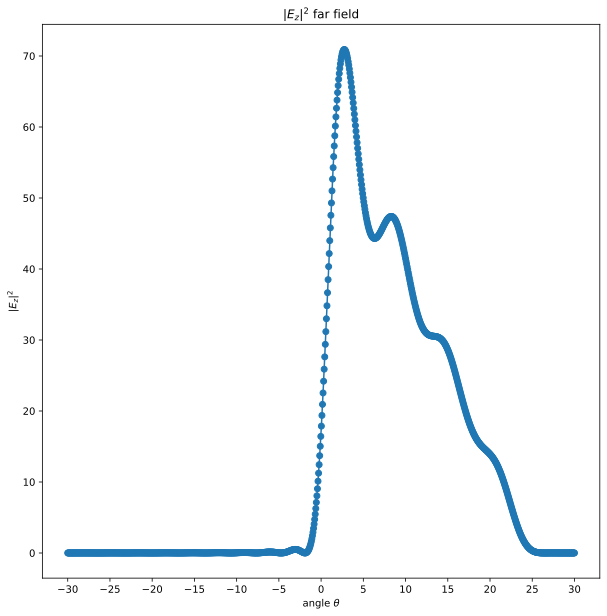

In [26]:
# anzhao1dianshu1
ff_distance = 1e6  # far-field distance from near-field monitor
ff_angle = 30  # far-field cone angle
ff_npts = 1000  # number of far-field points
# single-side far-field length
ff_length = ff_distance * math.tan(math.radians(ff_angle))  # far-field length
# [-ff_length, ff_length]
ff_lengths = np.linspace(-ff_length, ff_length, ff_npts)  # far-field lengths
# resolution
ff_res = ff_npts / (2 * ff_length)  # far-field length resolution

ff = sim.get_farfields(
    n2f_field,
    ff_res,
    center=mp.Vector3(0, ff_distance),
    size=mp.Vector3(x=2 * ff_length),
)
# [-angle, angle]
angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]
rel_enh = np.abs(ff["Ez"])**2

figure, ax = plt.subplots(figsize=(10, 10))
plt.plot(angles, rel_enh, "-o")
plt.title(r"$ {|E_z|}^2 $ far field")
ax.set_xlabel(r"angle $ \theta $")
ax.set_ylabel(r"$ {|E_z|}^2 $")
ax.set_xticks(range(-30, 35, 5))
index = np.argmax(rel_enh)
print(f"Output_angle of grating coupler: {angles[index]} degree")
print(f"max of far field: {np.max(rel_enh)}")


计算总场power

In [43]:
total_power = mp.get_fluxes(near_field)
print(total_power)

[940323.4406954832]


Text(0, 0.5, '$ {|E_z|}^2 $')

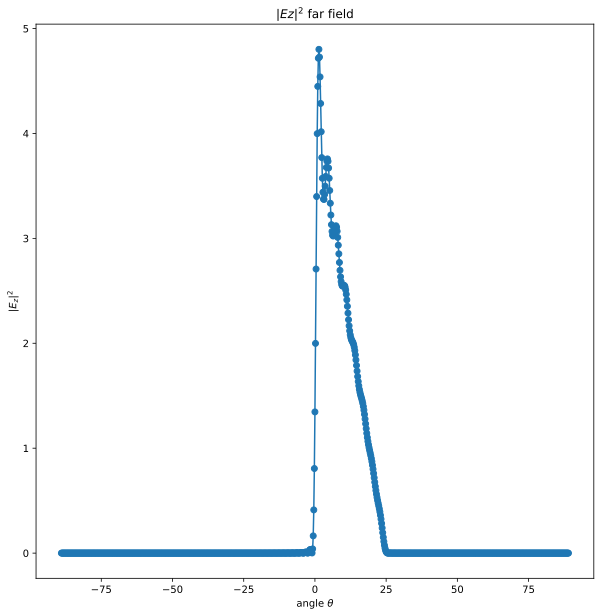

In [60]:
# 验证在0-25度光源传播下，monitor的远场角度分布
# 设置角度的分辨率为 0.5degree
d_angle = 0.2
ff_distance = 1e6
ff_angle = 89
ff_number = int(2 / d_angle) * ff_angle + 1
ff_angles = np.linspace(-ff_angle, ff_angle, ff_number)
ff_points = [
    mp.Vector3(fx, 1e6, 0) for fx in np.tan(np.radians(ff_angles)) * ff_distance
]

ob_list = [sim.get_farfield(n2f_field, ff_point) for ff_point in ff_points]
n2f_angle_Ez = [Ez[2] for Ez in ob_list]
rel_enh = np.abs(n2f_angle_Ez) ** 2
figure, ax = plt.subplots(figsize=(10, 10))
plt.plot(ff_angles, rel_enh, "-o")
plt.title(r"$ {|Ez|}^2 $ far field")
ax.set_xlabel(r"angle $ \theta$")
ax.set_ylabel(r"$ {|E_z|}^2 $")


**验证far field计算得到的power与mp.get_fluxes()相等**

In [61]:
d_length = []
for angle in ff_angles:
    # The length of each angle in the far field
    length = ff_distance / np.cos(np.radians(angle))
    d_length.append(np.radians(d_angle) * length)

print(f"The total length {np.sum(d_length)} um calculated by angles")

energy = 0
for ii in range(0, ff_number, 1):
    energy = energy + d_length[ii] * (np.abs(n2f_angle_Ez[ii]) ** 2)
print(f"The power of near_field is {energy}")

near_field_flux = mp.get_fluxes(near_field)
print(f"The power of near_field is {near_field_flux[0]}")


The total length 9689347.824509013 um calculated by angles
The power of near_field is 941089.9474803677
The power of near_field is 940323.4406954832


**Normalized power: 1**

(891,)


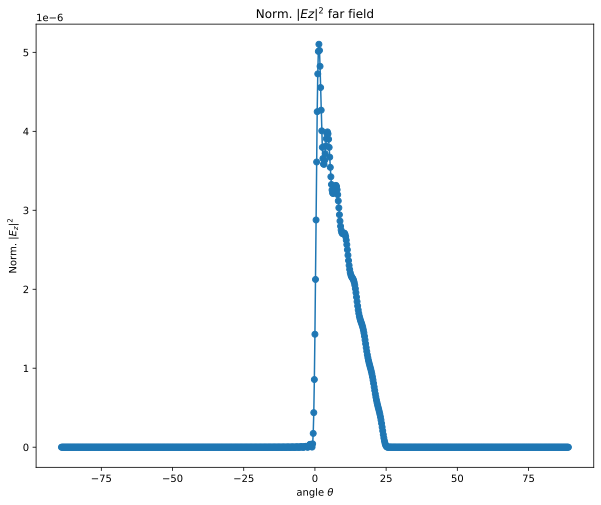

In [62]:
norm_rel = rel_enh / energy
figure, ax = plt.subplots(figsize=(10, 8))
plt.plot(ff_angles, norm_rel, "-o")
plt.title(r"Norm. $ {|Ez|}^2 $ far field")
ax.set_xlabel(r"angle $ \theta$")
ax.set_ylabel(r"Norm. $ {|E_z|}^2 $")
np.save("norm_rel_1.npy", norm_rel)
print(norm_rel.shape)



**验证归一化之后的enegy is 1**

In [56]:
norm_energy = 0
for ii in range(0, ff_number, 1):
    norm_energy = norm_energy + d_length[ii] * (norm_rel[ii])
print(f"The power of near_field is {norm_energy}")


The power of near_field is 1.0000000000000009


In [ ]:
# norm_rel_load = np.load('norm_rel.npy')
# figure= plt.figure(figsize=(10, 10))
# plt.plot(ff_angles, norm_rel_load, "-o")
